# Задание 1

In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from load_dataset import Dataset
import plotting

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
dataset = Dataset('C:/Users/volos/Documents/GitHub/ts_autumn/data/dataset/')

In [37]:
ts = dataset['dow_jones_0.csv']
ts.index = ts.index.map(pd.to_datetime)

In [38]:
ts_train, ts_test = ts[:-30], ts[-30:]

<AxesSubplot:xlabel='2018-11-30'>

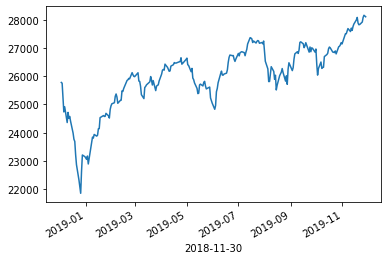

In [39]:
ts.plot()

In [40]:
ts.index

DatetimeIndex(['2018-12-03', '2018-12-04', '2018-12-06', '2018-12-07',
               '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13',
               '2018-12-14', '2018-12-17',
               ...
               '2019-11-15', '2019-11-18', '2019-11-19', '2019-11-20',
               '2019-11-21', '2019-11-22', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-29'],
              dtype='datetime64[ns]', name='2018-11-30', length=250, freq=None)

У нас график биржевого индекса за год. Следовательно, мы не найдем сезонность, присущую отчетным периодам. 
Гипотетически может быть недельная сезонность.

In [41]:
ts_diff = np.log(ts_train).diff(7).diff(1).dropna();

<AxesSubplot:xlabel='2018-11-30'>

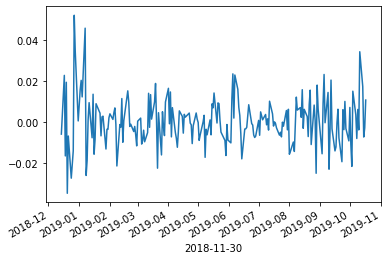

In [42]:
ts_diff.plot()

In [43]:
print(adfuller(ts_diff)[1])

8.775813923692088e-05


То есть, критерий Дики - Фуллера утверждает, что мы получили стационарный ряд

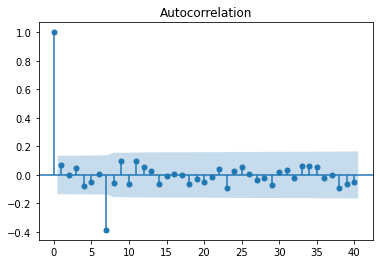

In [44]:
plot_acf(ts_diff, lags=40);

q, Q = (7, 0)

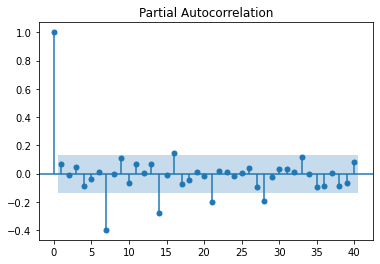

In [45]:
plot_pacf(ts_diff, lags=40);

(p, P) = (0, 7)

Не уверен, что тут поможет Бокс-Дженкинс, так как графики полной и частичной автокорреляции похожи.

In [54]:
from statsmodels.tsa.statespace import sarimax

In [55]:
pdq = (0, 1, 7)
PDQ = (7, 1, 0, 7)

model = sarimax.SARIMAX(np.log(ts_train), order=pdq, seasonal_order=PDQ)

In [56]:
res = model.fit()

In [57]:
preds = res.forecast(len(ts_test))

In [58]:
preds.index = ts_test.index

In [59]:
plotting.plot_ts(ts_train, np.exp(preds), ts_test)

Loading BokehJS ...

In [60]:
from sklearn.metrics import r2_score, mean_squared_error

In [61]:
r2_score(ts_test, np.exp(preds))

0.5630902820754853

In [62]:
mean_squared_error(ts_test, np.exp(preds))

83309.11466885629

In [63]:
res = np.exp(preds) - ts_test

<AxesSubplot:xlabel='2018-11-30'>

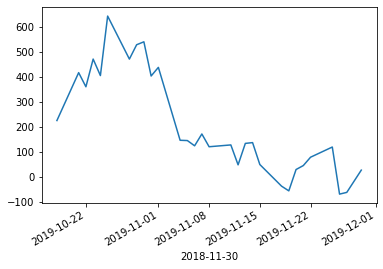

In [64]:
res.plot()

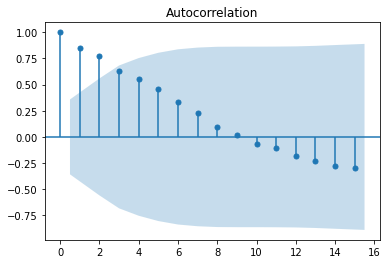

In [65]:
plot_acf(res);

In [66]:
adfuller(res)

(-1.2876005712708172,
 0.6348258031516676,
 0,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 234.16056891498874)

#### Выводы
* Есть остаточный тренд в остатках предсказания. Получить качественный прогноз не удалось. Предположительно, результат связан с природой ряда. Биржевой ряд имеет преимущественно стохастическую природу и, учитывая тот факт, что у нас данные только за год, не имеет сезонности.